In [196]:
import numpy as np
import tensorflow as tf
import sys
import string
import json

from numpy import array
from keras.preprocessing.text import one_hot
from keras.layers import Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, LSTM, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.layers.core import Activation, Dropout 

from keras.callbacks import ModelCheckpoint

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

In [127]:
def load_data(data_file=None):
    if data_file == None:
        return
    with open(data_file) as f:
        data = json.load(f)
    return data

In [128]:
folder = './data/large_files/stanford_sentiment/parsed_data/'
word2idx = load_data(folder + "sentiment_word2idx.json")
sentiment_binary_train = load_data(folder + "sentiment_binary_train.json")
sentiment_train = load_data(folder + "sentiment_train.json")
sentiment_binary_test = load_data(folder + "sentiment_binary_test.json")
sentiment_test = load_data(folder + "sentiment_test.json")

In [129]:
# the loaded samples has three type of labels -1,0,1, in which -1 indicates neutral sentiment.
# We exclude samples with neutral sentiment.
def exclude_neutral_sample(samples:dict):
    ssamples = {}
    for k, v in samples.items():
        if v[3][-1] != -1:
            ssamples[k] = v
    return ssamples
        
train_b = exclude_neutral_sample(sentiment_binary_train)
test_b = exclude_neutral_sample(sentiment_binary_test)

print("After filtering: # of training samples and # of test samples")
print("# of traing samples: ", len(train_b))
print("# of test samples: ", len(test_b))

After filtering: # of training samples and # of test samples
# of traing samples:  6920
# of test samples:  1821


In [130]:
def get_comment(wordidx, idx2word:dict):
    wordlist = []
    for idx in wordidx:
        if idx != -1:
            token = idx2word[idx]
            if token not in string.punctuation:
                wordlist.append(token)
    return wordlist

def get_comments_samples(samples:dict, idx2word:dict):
    comments = []
    targets = []
    for _, v in samples.items():
        if v[3][-1] != -1:
            comment = " ".join(get_comment(v[0], idx2word))
            label = v[3][-1]
            comments.append(comment)
            targets.append(label) 
    return comments, targets

In [131]:
idx2word = {v:k for k, v in word2idx.items()}
train_comments_o, train_targets = get_comments_samples(train_b, idx2word)
test_comments_o, test_targets = get_comments_samples(test_b, idx2word)

vocabulary_size = len(idx2word)
print('vocabulary_size' , vocabulary_size)

count0 = 0
count1 = 0
count2 = 0
for i in range(len(train_comments_o)):

    if train_targets[i] == 0:
        count0 += 1
    elif train_targets[i] == 1:
        count1 += 1
    else:
        count2 += 1
#     print(i, comments[i], targets[i])
    
print("0", count0)
print("1", count1)
print("-1", count2)

vocabulary_size 18647
0 3310
1 3610
-1 0


In [132]:
print(type(train_comments_o))
print(len(train_comments_o))
print(len(train_targets))
print(len(test_comments_o))
print(len(test_targets))
print(train_comments_o[1])
print(train_targets[1])

<class 'list'>
6920
6920
1821
1821
a very capable nailbiter
1


## Preprocessing data

### Define preprocessing data function

In [133]:
def remove_punctuation(samples):
    filtered_samples = []
    for i in samples:
        filtered_samples.append(i.translate(str.maketrans('', '', string.punctuation)))
    return filtered_samples

In [144]:
def tokenize(samples):
    tokenized_samples = []
    for s in samples:
        tokens = word_tokenize(s)
        tokenized_samples.append(tokens)
    return tokenized_samples

In [134]:
stopWords = set(stopwords.words('english'))
print(stopWords)

{'its', 'some', 'own', 'doesn', 'should', 'don', 'had', 'weren', 'won', 'the', 'while', 've', 'wasn', 'above', "you'd", 'shouldn', 'ours', 'll', 'over', 'themselves', 'just', 'needn', 'can', 'same', "shouldn't", "weren't", 'm', 'into', 'then', 'why', 'isn', 'to', 'been', 'through', 'about', 'very', "shan't", 'more', 'other', 'our', "couldn't", "aren't", 'her', "mightn't", 'd', 'didn', 'ourselves', 'between', 'wouldn', "won't", 'these', 'a', 'yourself', 'here', 'no', 'now', 'be', 'ain', "you'll", 'who', 'or', 'whom', 'after', 'both', 'than', "you're", 'i', 'has', 'only', 'his', 'most', 'she', 'of', 'so', 'each', 'any', 'with', 'their', 'such', 'against', 'when', 'my', 'those', 'hers', 'they', 'down', "you've", 'yourselves', 'yours', 'what', 'were', 're', 'that', 'not', 'theirs', 'have', "haven't", 'is', 'out', 'nor', 'do', 'did', 'if', 's', 'myself', 'o', 'off', 'again', 'until', 'does', 'once', 'hadn', 'up', 'it', 'on', "should've", 'by', "isn't", 'him', 'which', "she's", 'all', 'mustn

In [135]:
stopWords_revised = set(('at', 'how', 'each', 's', 'those', 'from','whom', 'if', 're', 'we', 'by','into', 'it', 'ma', 'than', "you'll", 
             'very', 'was', 'is', 'be', 'had', 'you', 'hers', 'off', 'her', 'your', 'other', 'on', 'down', 'its', 'should', 
             'which', 'now', 'ours', 'in', "you've", 'before', 'further', 'below', 'did',  'who', 'once', 'some', 'being', 
             'does', 'too', 'herself', 'about', 'my', 'are', 'during', 'few', 'an', 'do', 'over',  'themselves', 'the', 'why', 'a', 'same', 'all', 
             'own', 'with', 'under', 'myself', 'he', 'because', 'again', 'himself', 'these', 'that', 'am', 'through', 'll', 'so', 've', "you're", 'doing', 'between', 
             'when', 'ourselves', 'been', 'of', 'our', 'them', 'their', 'while', 'as', 'can', 'where', 'such', 'yourself', 'haven', 'they', 'theirs', 'm', 'both', 
                     "that'll", 'or', 'were', 'up', 'will', 'me', 'yours', 'itself', 'has', 'more', 
                'd', 'o', 'what', 'having', 't', 'this', 'after', 'no', 'then', 'above', 'out', 'nor', "should've", 'his', 
               "you'd", "she's", 'and', 'shan', 'until', 'here', 'for', 'just', 'him', 'to', 'have', 'she', 'yourselves', "it's", 'y', 'i', 'there'))


In [136]:
stopWords_revised_2 = set(('at', 'each', 's', 'those', 'from', 'if', 're', 'we', 'by','into', 'it', 'ma', "you'll", 
             'very', 'was', 'is', 'be', 'had', 'you', 'hers', 'off', 'her', 'your', 'other', 'on', 'down', 'its', 'should', 
              'now', 'ours', 'in', "you've", 'below', 'did', 'being', 
             'does', 'herself', 'about', 'my', 'are', 'an', 'do', 'themselves', 'the',  'a',  
             'own', 'myself', 'he',  'himself', 'these', 'that', 'am', 'll', 'so', 've', "you're", 'doing', 
            'ourselves', 'been', 'of', 'our', 'them', 'their', 'can', 'yourself', 'they', 'theirs', 'm', 
                     "that'll", 'or', 'were', 'up', 'will', 'me', 'yours', 'itself', 'has', 
                'd', 'o', 'having', 't', 'this', 'after', 'then', 'out', "should've", 'his', 
               "you'd", "she's", 'shan',  'here', 'for', 'him', 'to', 'have', 'she', 'yourselves', "it's", 'y', 'i', 'there'))


In [137]:
def remove_stopwords(samples):
    filtered_samples = []
    for s in samples:
        filstered_tokens = []
        for w in s:
            if w not in stopWords_revised_2:
                filstered_tokens.append(w)
        filtered_samples.append(filstered_tokens)
    return filtered_samples  

In [138]:
for i in range(100):
    print(i, ": ", train_comments_o[i])

0 :  rubbo runs through a remarkable amount of material in the film 's short 90 minutes
1 :  a very capable nailbiter
2 :  they just do n't work in concert
3 :  an interesting look behind the scenes of chicago-based rock group wilco ...
4 :  an essentially awkward version of the lightweight female empowerment picture we 've been watching for decades
5 :  credit director ramsay for taking the sometimes improbable story and making it feel realistic
6 :  a clever script and skilled actors bring new energy to the familiar topic of office politics
7 :  i am not generally a huge fan of cartoons derived from tv shows but hey arnold
8 :  the most consistently funny of the austin powers films
9 :  strange it is but delightfully so
10 :  lee 's achievement extends to his supple understanding of the role that brown played in american culture as an athlete a movie star and an image of black indomitability
11 :  and in a sense that 's a liability
12 :  there 's much tongue in cheek in the film and 

In [139]:
train_comments_1 = []
for comment in train_comments_o:
    new_str = comment.replace("n't", 'not')
    train_comments_1.append(new_str)
    
test_comments_1 = []
for comment in test_comments_o:
    new_str = comment.replace("n't", 'not')
    test_comments_1.append(new_str)

In [140]:
for i in range(100):
    print(i, ": ", train_comments_1[i])

0 :  rubbo runs through a remarkable amount of material in the film 's short 90 minutes
1 :  a very capable nailbiter
2 :  they just do not work in concert
3 :  an interesting look behind the scenes of chicago-based rock group wilco ...
4 :  an essentially awkward version of the lightweight female empowerment picture we 've been watching for decades
5 :  credit director ramsay for taking the sometimes improbable story and making it feel realistic
6 :  a clever script and skilled actors bring new energy to the familiar topic of office politics
7 :  i am not generally a huge fan of cartoons derived from tv shows but hey arnold
8 :  the most consistently funny of the austin powers films
9 :  strange it is but delightfully so
10 :  lee 's achievement extends to his supple understanding of the role that brown played in american culture as an athlete a movie star and an image of black indomitability
11 :  and in a sense that 's a liability
12 :  there 's much tongue in cheek in the film and 

In [141]:
train_comments_punc = remove_punctuation(train_comments_1)
test_comments_punc = remove_punctuation(test_comments_1)
print("punctuation removed")

punctuation removed


In [142]:
for i in range(100):
    print(i, ": ", train_comments_punc[i])

0 :  rubbo runs through a remarkable amount of material in the film s short 90 minutes
1 :  a very capable nailbiter
2 :  they just do not work in concert
3 :  an interesting look behind the scenes of chicagobased rock group wilco 
4 :  an essentially awkward version of the lightweight female empowerment picture we ve been watching for decades
5 :  credit director ramsay for taking the sometimes improbable story and making it feel realistic
6 :  a clever script and skilled actors bring new energy to the familiar topic of office politics
7 :  i am not generally a huge fan of cartoons derived from tv shows but hey arnold
8 :  the most consistently funny of the austin powers films
9 :  strange it is but delightfully so
10 :  lee s achievement extends to his supple understanding of the role that brown played in american culture as an athlete a movie star and an image of black indomitability
11 :  and in a sense that s a liability
12 :  there s much tongue in cheek in the film and there s n

In [145]:
train_comments_tokenized = tokenize(train_comments_punc)
test_comments_tokenized = tokenize(test_comments_punc)
print("tokenized")

tokenized


In [146]:
for i in range(100):
    print(i, ": ", train_comments_tokenized[i])

0 :  ['rubbo', 'runs', 'through', 'a', 'remarkable', 'amount', 'of', 'material', 'in', 'the', 'film', 's', 'short', '90', 'minutes']
1 :  ['a', 'very', 'capable', 'nailbiter']
2 :  ['they', 'just', 'do', 'not', 'work', 'in', 'concert']
3 :  ['an', 'interesting', 'look', 'behind', 'the', 'scenes', 'of', 'chicagobased', 'rock', 'group', 'wilco']
4 :  ['an', 'essentially', 'awkward', 'version', 'of', 'the', 'lightweight', 'female', 'empowerment', 'picture', 'we', 've', 'been', 'watching', 'for', 'decades']
5 :  ['credit', 'director', 'ramsay', 'for', 'taking', 'the', 'sometimes', 'improbable', 'story', 'and', 'making', 'it', 'feel', 'realistic']
6 :  ['a', 'clever', 'script', 'and', 'skilled', 'actors', 'bring', 'new', 'energy', 'to', 'the', 'familiar', 'topic', 'of', 'office', 'politics']
7 :  ['i', 'am', 'not', 'generally', 'a', 'huge', 'fan', 'of', 'cartoons', 'derived', 'from', 'tv', 'shows', 'but', 'hey', 'arnold']
8 :  ['the', 'most', 'consistently', 'funny', 'of', 'the', 'austin', 

In [147]:
train_comments_stopwords = remove_stopwords(train_comments_tokenized)
test_comments_stopwords = remove_stopwords(test_comments_tokenized)
print("stopwords removed")

stopwords removed


In [148]:
for i in range(100):
    print(i, ": ", train_comments_stopwords[i])

0 :  ['rubbo', 'runs', 'through', 'remarkable', 'amount', 'material', 'film', 'short', '90', 'minutes']
1 :  ['capable', 'nailbiter']
2 :  ['just', 'not', 'work', 'concert']
3 :  ['interesting', 'look', 'behind', 'scenes', 'chicagobased', 'rock', 'group', 'wilco']
4 :  ['essentially', 'awkward', 'version', 'lightweight', 'female', 'empowerment', 'picture', 'watching', 'decades']
5 :  ['credit', 'director', 'ramsay', 'taking', 'sometimes', 'improbable', 'story', 'and', 'making', 'feel', 'realistic']
6 :  ['clever', 'script', 'and', 'skilled', 'actors', 'bring', 'new', 'energy', 'familiar', 'topic', 'office', 'politics']
7 :  ['not', 'generally', 'huge', 'fan', 'cartoons', 'derived', 'tv', 'shows', 'but', 'hey', 'arnold']
8 :  ['most', 'consistently', 'funny', 'austin', 'powers', 'films']
9 :  ['strange', 'but', 'delightfully']
10 :  ['lee', 'achievement', 'extends', 'supple', 'understanding', 'role', 'brown', 'played', 'american', 'culture', 'as', 'athlete', 'movie', 'star', 'and', 'ima

In [149]:
def combine(tokenized_comments):
    text = []
    for comment in tokenized_comments:
        text += comment
    return text

all_words = combine(train_comments_stopwords) + combine(test_comments_stopwords)
print(all_words)
# all_text1 = ' '.join(train_comments_stopwords)
# all_text2 = ' '.join(test_comments_stopwords)
# words1 = all_text1.split()
# words2 = all_text2.split()
# all_words = words1 + words2

['rubbo', 'runs', 'through', 'remarkable', 'amount', 'material', 'film', 'short', '90', 'minutes', 'capable', 'nailbiter', 'just', 'not', 'work', 'concert', 'interesting', 'look', 'behind', 'scenes', 'chicagobased', 'rock', 'group', 'wilco', 'essentially', 'awkward', 'version', 'lightweight', 'female', 'empowerment', 'picture', 'watching', 'decades', 'credit', 'director', 'ramsay', 'taking', 'sometimes', 'improbable', 'story', 'and', 'making', 'feel', 'realistic', 'clever', 'script', 'and', 'skilled', 'actors', 'bring', 'new', 'energy', 'familiar', 'topic', 'office', 'politics', 'not', 'generally', 'huge', 'fan', 'cartoons', 'derived', 'tv', 'shows', 'but', 'hey', 'arnold', 'most', 'consistently', 'funny', 'austin', 'powers', 'films', 'strange', 'but', 'delightfully', 'lee', 'achievement', 'extends', 'supple', 'understanding', 'role', 'brown', 'played', 'american', 'culture', 'as', 'athlete', 'movie', 'star', 'and', 'image', 'black', 'indomitability', 'and', 'sense', 'liability', 'much

In [150]:
# Create your dictionary that maps vocab words to integers here
from collections import Counter
counts = Counter(all_words)
print(type(counts))

vocab = sorted(counts, key=counts.get, reverse=True)

# Note that index start from 1
vocab_to_int = {word:i for i, word in enumerate(vocab, 1)}

<class 'collections.Counter'>


In [151]:
print("type of vocab", type(vocab))
print('total # of words: ', len(vocab_to_int))
print("first word:", vocab[0])
print("last word:", vocab[-1])
print("first word index:", vocab_to_int[vocab[0]])
print("last word index", vocab_to_int[vocab[-1]])

type of vocab <class 'list'>
total # of words:  16547
first word: and
last word: plutonium
first word index: 1
last word index 16547


In [152]:
index2word = {idx:word for word, idx in vocab_to_int.items()}

In [153]:
def convert_to_int(reviews, vocab_to_int):
    # Convert the reviews to integers, same shape as reviews list, but with integers
    print('# of reviews before index: ', len(reviews))
    reviews_ints = []
    for review in reviews:
        reviews_ints.append([vocab_to_int[word] for word in review])

    print('# of reviews after index: ', len(reviews_ints))
    return reviews_ints

In [154]:
x_train = convert_to_int(train_comments_stopwords, vocab_to_int)

# of reviews before index:  6920
# of reviews after index:  6920


In [155]:
# test
print(x_train[7])
print(train_comments_o[7])
text = [index2word[idx] for idx in x_train[7]]
print(text)

[3, 1227, 850, 984, 3457, 5238, 332, 383, 6, 1753, 1482]
i am not generally a huge fan of cartoons derived from tv shows but hey arnold
['not', 'generally', 'huge', 'fan', 'cartoons', 'derived', 'tv', 'shows', 'but', 'hey', 'arnold']


In [159]:
x_test = convert_to_int(test_comments_stopwords, vocab_to_int)

# of reviews before index:  1821
# of reviews after index:  1821


In [160]:
from collections import Counter

# Create length to frequency map
x_train_lens_map = Counter([len(x) for x in x_train])
x_train_lens = [len(x) for x in x_train]
print("Zero-length reviews: {}".format(x_train_lens_map[0]))
print("Maximum train example length: {}".format(max(x_train_lens_map)))

Zero-length reviews: 2
Maximum train example length: 36


In [161]:
type(list(x_train_lens_map.keys()))

list

In [162]:
# Create length to frequency map
x_test_lens_map = Counter([len(x) for x in x_test])
x_test_lens = [len(x) for x in x_test]
print("Zero-length reviews: {}".format(x_test_lens_map[0]))
print("Maximum test example length: {}".format(max(x_test_lens_map)))


ave_len = 0
for i in x_train:
    ave_len += len(i) 
ave_len = ave_len / len(x_train)
print(ave_len)

ave_len = 0
for i in x_test:
#     print(i)
    ave_len += len(i)  
ave_len = ave_len / len(x_test)
print(ave_len)

Zero-length reviews: 0
Maximum test example length: 31
11.324566473988439
11.314662273476111


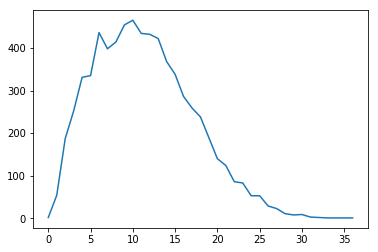

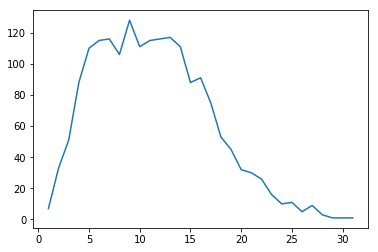

In [163]:
import matplotlib.pyplot as plt
plt.plot(list(x_train_lens_map.keys()), list(x_train_lens_map.values()))
# plt.axis([1000, 1500, 0, 55])
plt.show()

plt.plot(list(x_test_lens_map.keys()), list(x_test_lens_map.values()))
# plt.axis([1000, 1500, 0, 55])
plt.show()

In [164]:
def left_padding(reviews_ints, seq_len):
    
    # The features created here are the data that we are going to train and test the network

    # Create features with shape (len(reviews_ints), seq_len) and initialized with zeros
    features = np.zeros((len(reviews_ints), seq_len), dtype=int)

    print(features.shape)
    # Create list holding the length for each review
    lengths = []

    # row is the review in forms of a list of integers
    for i, row in enumerate(reviews_ints):

        # left padding
        features[i, -len(row):] = np.array(row)[:seq_len]
        
        # record the length of each review. This might be useful when we want to use sequence_length argument
        # of tf.nn.dynamic_rnn(...)
        lengths.append(len(row) if len(row) < seq_len else seq_len)
        
    return features, lengths

In [166]:
## test

sample1 = [4,6,7,2,3,5,7,8,1]
sample2 = [1,2,3,4,6,7,2,3,5,7]
sample3 = [1,2,3,4,6,7,2,3,26,1, 11, 12]
sample4 = [8,7,3]
samples = []
samples.append(sample1)
samples.append(sample2)
samples.append(sample3)
samples.append(sample4)
features_, lengths_ = left_padding(samples, 12)

print(features_)
print(lengths_)

(4, 12)
[[ 0  0  0  4  6  7  2  3  5  7  8  1]
 [ 0  0  1  2  3  4  6  7  2  3  5  7]
 [ 1  2  3  4  6  7  2  3 26  1 11 12]
 [ 0  0  0  0  0  0  0  0  0  8  7  3]]
[9, 10, 12, 3]


In [178]:
x_train_f = []
y_train_f = []
for idx in range(len(x_train)):
    if len(x_train[idx]) != 0:
        x_train_f.append(x_train[idx])
        y_train_f.append(train_targets[idx])

x_test_f = []
y_test_f = []
for idx in range(len(x_test)):
    if len(x_test[idx]) != 0:
        x_test_f.append(x_test[idx])
        y_test_f.append(test_targets[idx])

In [179]:
seq_len = 36
x_train_p, x_train_len = left_padding(x_train_f, seq_len)
x_test_p, x_test_len = left_padding(x_test_f, seq_len)

(6918, 36)
(1821, 36)


In [169]:
x_train_p[:5,:seq_len]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,  4969,
          768,    52,   446,   609,   154,     5,   248,   835,   113],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,  1952,  7806],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,    19,     3,    42,  2268],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
   

In [170]:
x_train_ = np.append(x_train_p, x_test_p[:1086], axis=0)
x_test_ = x_test_p[1086:]

y_train_ = np.array(np.append(y_train_f, y_test_f[:1086], axis=0))
y_test_ = np.array(y_test_f[1086:])

x_train_len_ = np.append(x_train_len, x_test_len[:1086], axis=0)
x_test_len_ = x_test_len[1086:]

print(len(x_train_))
print(len(x_test_))
print(len(y_train_))
print(len(y_test_))
print(len(x_train_len_))
print(len(x_test_len_))

8004
735
8004
735
8004
735


In [171]:
print(x_train_.shape)
print(x_test_.shape)
print(y_train_.shape)
print(y_test_.shape)
# print(x_train_len_.shape)
# print(x_test_len_.shape)

(8004, 36)
(735, 36)
(8004,)
(735,)


In [197]:
def LSTM_model(input_shape, vocab_size, embedding_dim=256, rnn_units=128, dropout_prob=0.8):
    """
    :param input_shape: Tuple of input shape
    :param vocab_size: Number of unique English words in the dataset
    :return: Keras model built, but not trained
    """
    model = Sequential()
    # Embedding layer
    model.add(Embedding(vocab_size, embedding_dim, input_shape=input_shape[1:]))
    # Encoder with bidirectional RNN
    model.add(LSTM(rnn_units, activation='relu', return_sequences=False))
    model.add(Dropout(dropout_prob))  
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # checkpoint
    filepath="weights.best.hdf5"
#     filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    return model, callbacks_list

In [203]:
def BiLSTM_model(input_shape, vocab_size, embedding_dim=256, rnn_units=128, dropout_prob=0.8):
    """
    :param input_shape: Tuple of input shape
    :param vocab_size: Number of unique English words in the dataset
    :return: Keras model built, but not trained
    """
    model = Sequential()
    # Embedding layer
    model.add(Embedding(vocab_size, embedding_dim, input_shape=input_shape[1:]))
    # Encoder with bidirectional RNN
    model.add(Bidirectional(LSTM(rnn_units, activation='relu', return_sequences=False)))
    model.add(Dropout(dropout_prob))  
    model.add(Dense(1, activation='sigmoid'))
    
        # checkpoint
    filepath="weights.best.hdf5"
#     filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model, callbacks_list

In [204]:
vocab_size = len(vocab_to_int) + 1


embedding_dims = [256]
rnn_units = [128, 256]
dropout_probs = [0.7, 0.8]

for e in embedding_dims:
    for r in rnn_units:
        for d in dropout_probs:
            print("---------------------------------------------------------------------")
            print("e", e)
            print("r", r)
            print("d", d)
            
            # test LSTM, BiLSTM, GRU, BiGRU
            custom_rnn_model, callbacks_list = BiLSTM_model(x_train_.shape, vocab_size, e, r, d)
#             custom_rnn_model, callbacks_list = LSTM_model(x_train_.shape, vocab_size, e, r, d)
            print(custom_rnn_model.summary())
            custom_rnn_model.fit(x_train_, y_train_, batch_size=400, epochs=10, validation_split=0.1, callbacks=callbacks_list,)
            print(custom_rnn_model.metrics_names)
            
            custom_rnn_model.load_weights("weights.best.hdf5")
            custom_rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            result = custom_rnn_model.evaluate(x=x_test_, y=y_test_, batch_size=300)
            print(result)

---------------------------------------------------------------------
e 256
r 128
d 0.7
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 36, 256)           4236288   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dropout_29 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 257       
Total params: 4,630,785
Trainable params: 4,630,785
Non-trainable params: 0
_________________________________________________________________
None
Train on 7203 samples, validate on 801 samples
Epoch 1/10
7203/7203 [==============================] - 57s - loss: 0.6910 - acc: 0.5278 - val_loss: 0.6915 - val_acc: 0.488

Train on 7203 samples, validate on 801 samples
Epoch 1/10
7203/7203 [==============================] - 87s - loss: 0.6902 - acc: 0.5233 - val_loss: 0.6878 - val_acc: 0.4894
Epoch 2/10
7203/7203 [==============================] - 79s - loss: 0.6420 - acc: 0.6504 - val_loss: 0.6021 - val_acc: 0.6966
Epoch 3/10
7203/7203 [==============================] - 79s - loss: 0.4760 - acc: 0.8559 - val_loss: 0.6808 - val_acc: 0.8027
Epoch 4/10
7203/7203 [==============================] - 78s - loss: 0.2805 - acc: 0.9267 - val_loss: 0.9920 - val_acc: 0.7965
Epoch 5/10
7203/7203 [==============================] - 79s - loss: 0.2031 - acc: 0.9489 - val_loss: 0.5569 - val_acc: 0.8140
Epoch 6/10
7203/7203 [==============================] - 78s - loss: 0.1678 - acc: 0.9492 - val_loss: 0.5612 - val_acc: 0.7353
Epoch 7/10
7203/7203 [==============================] - 79s - loss: 0.4622 - acc: 0.9064 - val_loss: 0.4808 - val_acc: 0.7840
Epoch 8/10
7203/7203 [==============================] - 79s - loss: 0.2